In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import ParameterGrid, GridSearchCV, TimeSeriesSplit, learning_curve
from sklearn import linear_model
from scipy.stats.mstats import winsorize

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, FunctionTransformer, KBinsDiscretizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2
from pandas.tseries.holiday import USFederalHolidayCalendar

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df_hour= pd.read_csv("hour.csv", sep= ",", parse_dates=["dteday"], dayfirst= True, index_col= "instant" )
df_hour.head(5)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


In [3]:
X= df_hour.drop(columns=["cnt"])
y= df_hour["cnt"]

In [4]:
#Separating the data in train and test
X_train = X.loc[X["dteday"]<'2012-10'] 
y_train = y.loc[X["dteday"]<'2012-10'] 

X_test = X.loc[(X["dteday"]>='2012-10')]
y_test = y.loc[(X["dteday"]>='2012-10')]

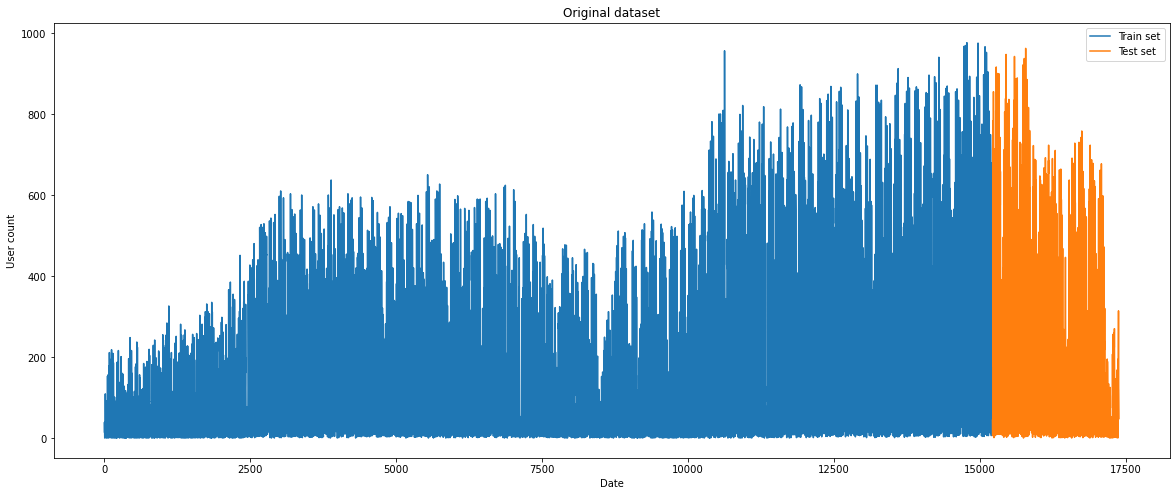

In [5]:
plt.figure(figsize=(20,8))
ax= sns.lineplot(x= X_train.index, y= y_train, label='Train set') 
ax= sns.lineplot(x= X_test.index, y= y_test, label='Test set')
ax.set(xlabel= "Date", ylabel= "User count", title= "Original dataset")
plt.show()

## 1. Exploratory Data Analysis 

### a. Ensuring data quality (correctness, consistency, missing values, outliers...).

In [6]:
#First explore types of the variables
X_train.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

In [7]:
#Understanding weathersit variable
X_train["weathersit"].value_counts() 

Clear, Few clouds, Partly cloudy, Partly cloudy                                            10130
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                3738
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     1254
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                     3
Name: weathersit, dtype: int64

In [8]:
#Identifying null values
X_train.isnull().sum()

dteday         0
hr             0
weathersit    86
temp          89
atemp         89
hum           89
windspeed     88
casual         0
registered     0
dtype: int64

#### We would dig deeper into the null values. Is there any pattern in the null values?

In [9]:
X_train[X_train["weathersit"].isnull()].head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered
instant,,,,,,,,,
329,2011-01-15,4,NaN,0.16,0.2273,0.59,0.0000,0,5
957,2011-02-12,11,NaN,0.30,0.2727,0.28,0.3284,30,84
1053,2011-02-16,14,NaN,0.46,0.4545,0.28,0.4179,17,65
1102,2011-02-18,15,NaN,0.66,0.6212,0.36,0.3284,55,117
1303,2011-02-27,11,NaN,0.36,0.3485,0.62,0.1343,33,92


In [10]:
X_train[X_train["temp"].isnull()].head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered
instant,,,,,,,,,
56,2011-01-03,10,"Clear, Few clouds, Partly cloudy, Partly cloudy",NaN,0.1667,0.43,0.2537,11,33
134,2011-01-06,19,"Clear, Few clouds, Partly cloudy, Partly cloudy",NaN,0.2576,0.55,0.0896,3,109
280,2011-01-13,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",NaN,0.1212,0.50,0.3582,0,2
621,2011-01-29,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",NaN,0.2273,0.64,0.1642,0,15
851,2011-02-07,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",NaN,0.3485,0.70,0.0000,3,75


In [11]:
X_train[X_train["atemp"].isnull()].head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered
instant,,,,,,,,,
354,2011-01-16,5,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,NaN,0.56,0.1642,1,1
748,2011-02-03,13,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.20,NaN,0.40,0.4179,4,47
981,2011-02-13,12,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.36,NaN,0.32,0.4627,58,94
1550,2011-03-09,22,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.32,NaN,0.93,0.1642,4,17
1579,2011-03-11,6,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,NaN,0.81,0.2836,1,31


In [12]:
X_train[X_train["hum"].isnull()].head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered
instant,,,,,,,,,
251,2011-01-11,19,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.16,0.2273,NaN,0.0000,0,51
287,2011-01-13,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.14,0.1212,NaN,0.3284,2,137
386,2011-01-17,13,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.18,0.1970,NaN,0.1343,13,80
500,2011-01-22,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.06,0.1061,NaN,0.0896,0,39
525,2011-01-23,23,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.06,0.0606,NaN,0.2239,4,17


In [13]:
X_train[X_train["windspeed"].isnull()].head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered
instant,,,,,,,,,
55,2011-01-03,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.16,0.1364,0.43,NaN,7,81
278,2011-01-13,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.14,0.1212,0.59,NaN,1,6
535,2011-01-24,10,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.10,0.1364,0.42,NaN,6,34
547,2011-01-24,22,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.14,0.1364,0.63,NaN,3,32
1017,2011-02-15,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.30,0.2727,0.49,NaN,7,12


Apparently there is no pattern within the NaNs. We would decide a technique to input them afterwards. 

We also use describe method to get a quick view of the different variables. Numerical variables are already scaled within 0 and 1.
There are no evident outliers that we can detect at this point within the minimum and maximum values. However, we would still assess possible outliers in a further step.

In [14]:
X_train.drop(columns=["casual", "registered"]).describe()

,hr,temp,atemp,hum,windspeed
count,15211.000000,15122.000000,15122.000000,15122.000000,15123.000000
mean,11.547301,0.512754,0.488950,0.624960,0.191535
std,6.913073,0.195820,0.174732,0.195852,0.122365
min,0.000000,0.020000,0.000000,0.000000,0.000000
25%,6.000000,0.340000,0.333300,0.470000,0.104500
50%,12.000000,0.540000,0.500000,0.620000,0.194000
75%,18.000000,0.660000,0.621200,0.780000,0.253700
max,23.000000,1.000000,1.000000,1.000000,0.850700


### b. Plotting clear and meaningful figures.

First we would understand the distribution of the numerical variables given in the dataset

In [15]:
sns.set(style="darkgrid")

Text(0.5, 0.98, 'Distribution of numerical data')

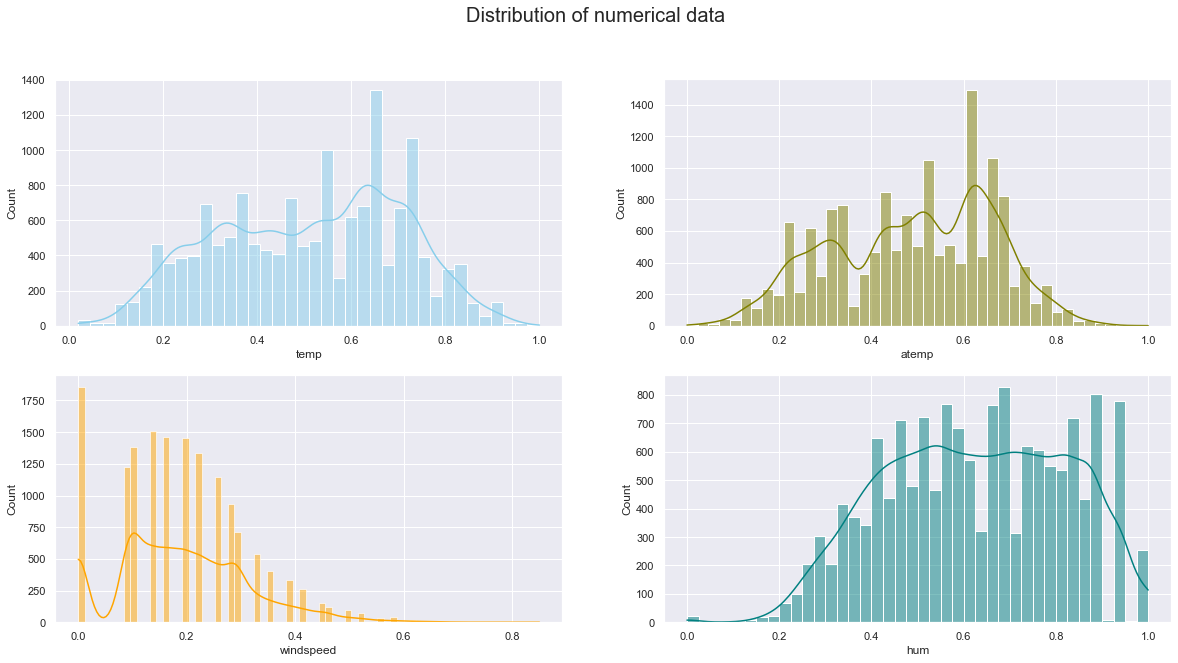

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
sns.histplot(data=X_train, x="temp", kde=True, color="skyblue", ax=axes[0, 0])
sns.histplot(data=X_train, x="atemp", kde=True, color="olive", ax=axes[0, 1])
sns.histplot(data=X_train, x="windspeed", kde=True, color="orange", ax=axes[1, 0])
sns.histplot(data=X_train, x="hum", kde=True, color="teal", ax=axes[1, 1])
fig.suptitle("Distribution of numerical data", size= 20)

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'User count'),
 Text(0.5, 1.0, 'Distribution of casual and registered users')]

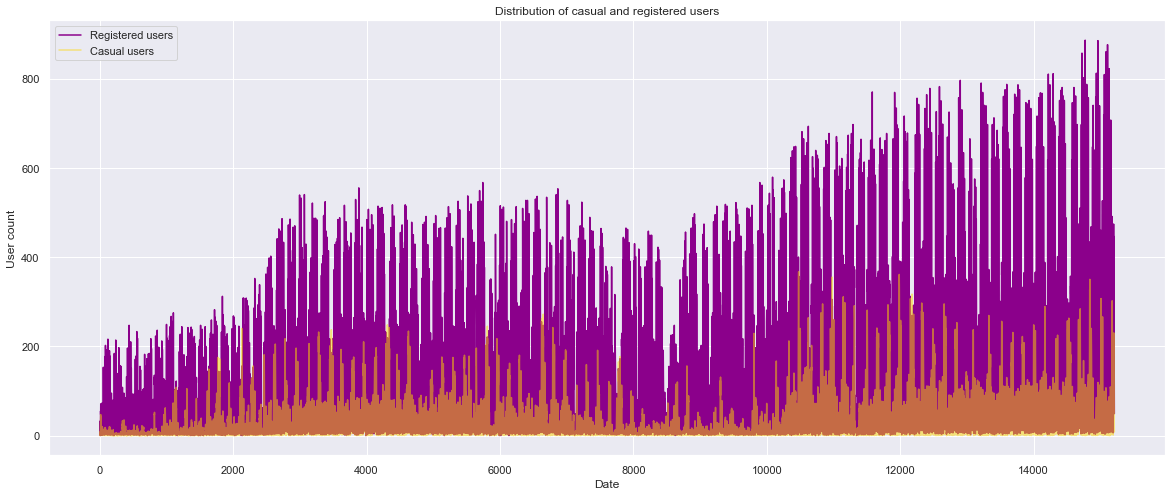

In [17]:
plt.figure(figsize=(20,8))
ax= sns.lineplot(x= X_train.index, y= X_train["registered"] , label='Registered users', color= "darkmagenta")
ax= sns.lineplot(x= X_train.index, y= X_train["casual"] , label='Casual users', color= "gold", alpha= 0.5)
ax.set(xlabel= "Date", ylabel= "User count", title= "Distribution of casual and registered users")

The variables of casual and registered, even if not used as features, may help us understand the users. The majority of the users are registered. And these are the ones who show the highest range.

### c. Giving insights on what seems relevant for prediction and what does not.

First, we would plot the different variables to see if there is any trend impacting the count of users

Text(0.5, 0.98, 'Numerical variables relationship with cnt')

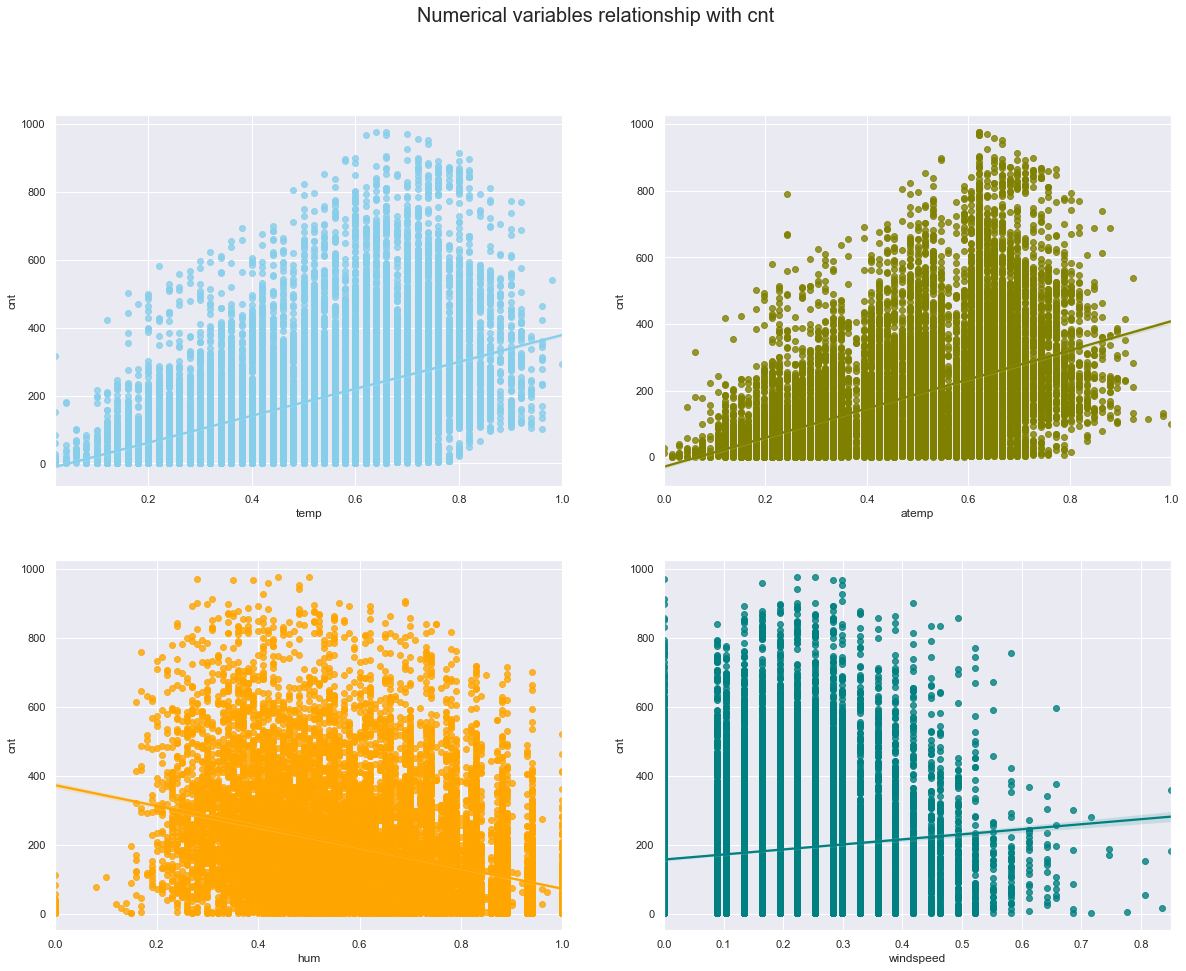

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

#Scatterplots of the data
sns.regplot(x= X_train["temp"], y= y_train, ax= axes[0,0], color="skyblue")
sns.regplot(x= X_train["atemp"], y= y_train, ax= axes[0,1],  color="olive")
sns.regplot(x= X_train["hum"], y= y_train, ax= axes[1,0], color="orange")
sns.regplot(x= X_train["windspeed"], y= y_train, ax= axes[1,1],color="teal" )

fig.suptitle ("Numerical variables relationship with cnt", size= 20)

As we can see there is a positive relationship between temp and atemp with the count of users. The other two variables don't seem to have a clear relationship with the cnt data

For confirming this relationship within the variables, we calculated the correlation coefficient vs. the target variable

In [19]:
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')  

In [20]:
weather_temp = pd.DataFrame(X_train['weathersit'].fillna(method='ffill')) #Before calculating correlations within variables we replace Na's

In [21]:
weather_names = weather_temp["weathersit"].unique()
x_weather = pd.DataFrame(enc.fit_transform(weather_temp), columns=weather_names).set_index(X_train.index) #Encoding of weathersit variable

In [22]:
x_temp = pd.concat((X_train, x_weather), axis=1).drop(columns=['weathersit', 'dteday']).fillna(method='ffill') #Temporal dataframes that joins X_train with the new encoded variables
pd.concat((x_temp, pd.DataFrame(y_train)), axis=1).corr()['cnt'].to_frame()[:-1].sort_values("cnt") #correlation between X and y (cnt)

,cnt
hum,-0.329399
"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",-0.129935
"Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog",-0.054260
"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",-0.008754
windspeed,0.100065
"Clear, Few clouds, Partly cloudy, Partly cloudy",0.126317
hr,0.399272
atemp,0.429321
temp,0.435822
casual,0.711362


Temperature and feeling temperature are the variables which initially seem to have a higher impact on cnt variable. We also included casual and registered rows to confirm our hypothesis, that registered users have a higher impact on the total count.

Next, we would also take into account the chi score of each variable to also asses each variable's significance for predicting the target variable.

In [23]:
chis = (pd.DataFrame(sklearn.feature_selection.chi2(x_temp, y_train), columns=x_temp.columns).sort_values(by= 0, axis=1)).drop(columns=["casual", "registered"])
chis
#[0]= chi score, [1]= pvalue

,windspeed,hum,atemp,temp,"Clear, Few clouds, Partly cloudy, Partly cloudy","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist","Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog","Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",hr
0,85.892993,162.595125,249.709019,305.281032,322.386663,339.469883,620.22976,753.974386,24243.491785
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.986389,0.000000


[Text(0.5, 1.0, 'Chi-Score')]

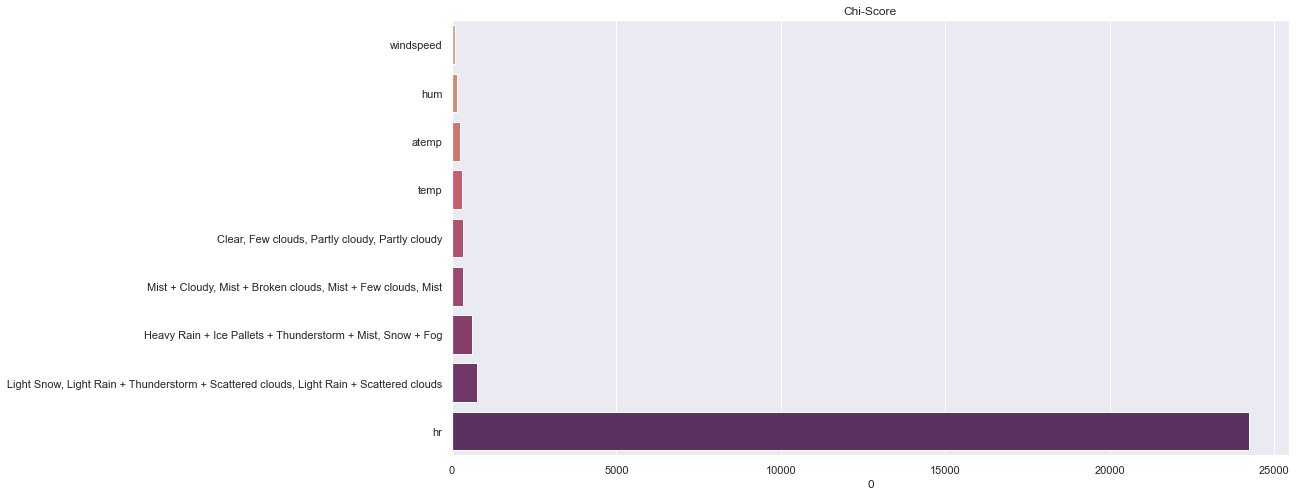

In [24]:
plt.figure(figsize=(15,8))
ax= sns.barplot(x= chis.iloc[0], y= chis.columns, orient= "h", palette = "flare") #orient h= horizontal, we selected chis[0], corresponding to the chi score
ax.set(title= "Chi-Score")

Apparently the feature that can have the higher impact on the "cnt" variable is hour. This followed by "weathersit". However, after the feature engineering we could have variables that have a higher impact on our response variable.

### d. BONUS: Checking possibly redundant variables via correlations.

In [25]:
x_temp.corr()

,hr,temp,atemp,hum,windspeed,casual,registered,"Clear, Few clouds, Partly cloudy, Partly cloudy","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist","Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"
hr,1.000000,0.139134,0.134820,-0.280621,0.143831,0.310154,0.379159,0.035357,0.000243,0.015566,-0.048541
temp,0.139134,1.000000,0.987249,-0.068716,-0.031496,0.468114,0.370276,0.097653,-0.023376,-0.072975,-0.059005
atemp,0.134820,0.987249,1.000000,-0.050688,-0.066918,0.460476,0.364973,0.096993,-0.024294,-0.078069,-0.054992
hum,-0.280621,-0.068716,-0.050688,1.000000,-0.283999,-0.344875,-0.282863,-0.383897,0.018540,0.311033,0.218881
windspeed,0.143831,-0.031496,-0.066918,-0.283999,1.000000,0.088244,0.091487,0.007866,0.001433,0.067566,-0.051903
casual,0.310154,0.468114,0.460476,-0.344875,0.088244,1.000000,0.525000,0.133265,-0.009539,-0.120379,-0.067933
registered,0.379159,0.370276,0.364973,-0.282863,0.091487,0.525000,1.000000,0.108130,-0.007392,-0.116847,-0.042852
"Clear, Few clouds, Partly cloudy, Partly cloudy",0.035357,0.097653,0.096993,-0.383897,0.007866,0.133265,0.108130,1.000000,-0.019994,-0.428921,-0.815288
"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",0.000243,-0.023376,-0.024294,0.018540,0.001433,-0.009539,-0.007392,-0.019994,1.000000,-0.004232,-0.008044
"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",0.015566,-0.072975,-0.078069,0.311033,0.067566,-0.120379,-0.116847,-0.428921,-0.004232,1.000000,-0.172564


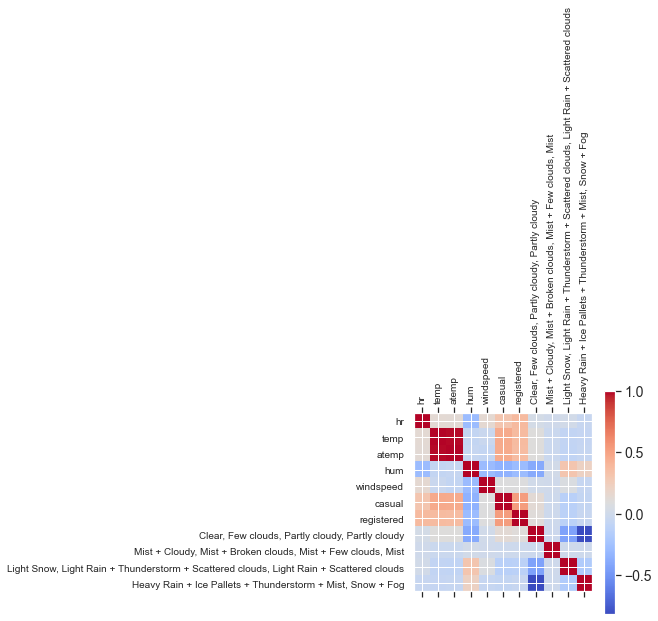

In [26]:
corrs = x_temp.corr()

plt.matshow(corrs, cmap=plt.cm.coolwarm) #Matshow returns a matrix plot. Params= (input matrix, cmap= color map. we set it to coolwarm colormapping )
plt.xticks(range(corrs.shape[1]), corrs.columns, fontsize=10, rotation=90) #xlabels. params= (number of titles, name of titles, fontsize, rotation)
plt.yticks(range(corrs.shape[1]), corrs.columns, fontsize=10) #ylabels
cb = plt.colorbar() #Reference legend for color
cb.ax.tick_params(labelsize=14) #Font size of reference legend

From the correlation matrix we can evidence a high correlation within temp and atemp variables and also within the encoded variables from weathersit. For this reason we would delete the atemp variable, as temp has a higher impact on the objective variable (according to correlation coefficient and chi score).

In [27]:
X_train= X_train.drop(columns="atemp")
X_test= X_test.drop(columns="atemp")

## 2. Data Engineering  

In [28]:
sklearn.set_config(display="diagram") #Visualizing pipelines and column transformers

### a. Discussion on missing values and outliers

Text features would have a different approach than numeric features. Outliers would only be treated on the numerical features and for this reason we created a column transformer (ct_numerical) that takes this into acccount.


In [29]:
#We use winsorize method for trating outliers. This function uses a floor and a cap for imputing values that are outside of a predefine tail cut.
def winsor_01(serie):
    return winsorize(serie, limits= [0.01, 0.01]) #limits= lower and upper percentile for the cut. In this example everything outside of the 98% CI would be imputed

In [30]:
winsor01= FunctionTransformer(winsor_01)

In [31]:
#This column transformer uses the numerical pipeline just on non encoded variables. The other, non-numerical variables are passed
ct_numerical= ColumnTransformer([
    ("non_encoded", winsor01, slice(0,3)), #numerical variables
    ("encoded", "passthrough", slice(3,70)) #encoded variables
])
ct_numerical

ColumnTransformer(transformers=[('non_encoded',
                                 FunctionTransformer(func=<function winsor_01 at 0x7fc4dd41c700>),
                                 slice(0, 3, None)),
                                ('encoded', 'passthrough', slice(3, 70, None))])

### b. Treatment of text and date features

The text column we have in our data would be encoded and treated as a categorical variable. Before doing this we have to impute null values. In this case we consider that the most appropiate value for nulls would be the one of the previous hour as it would be the most similar one.

In [32]:
def impute_last(series):
    return (series.fillna(method = 'ffill')).to_frame()

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Clear, Few clouds, Partly cloudy, Partly cloudy'),
  Text(1, 0, 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist'),
  Text(2, 0, 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds'),
  Text(3, 0, 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog')])

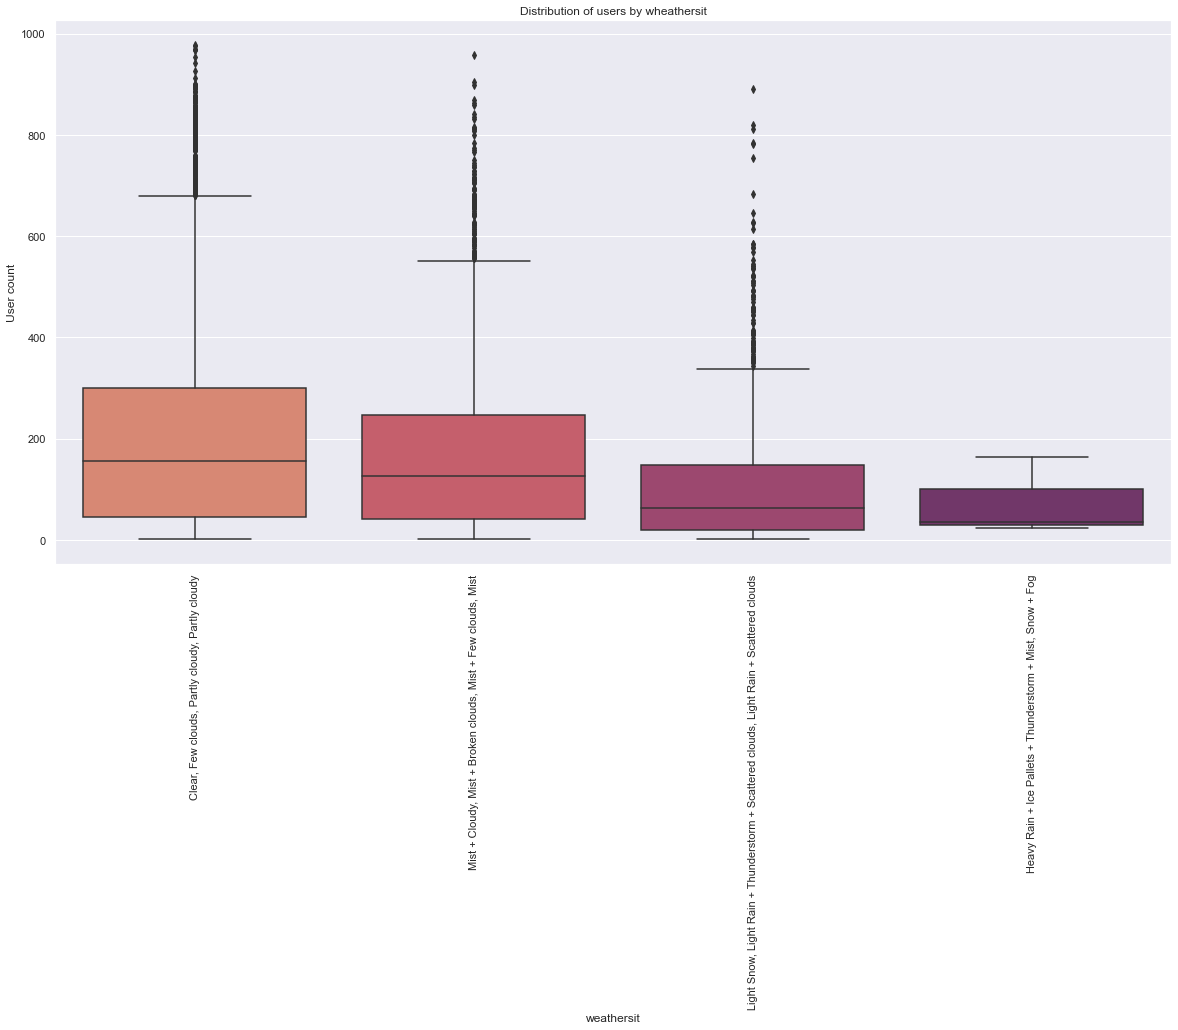

In [33]:
plt.figure(figsize=(20,10))
data_boxplots_text= pd.concat((X_train, y_train), axis=1) #axis =1 for concatenating along the columns. Here we are joining both X and y in the same df
ax= sns.boxplot(x= "weathersit", y="cnt", data= data_boxplots_text, palette= "flare")
ax.set(ylabel= "User count", title= "Distribution of users by wheathersit")
plt.xticks (rotation= 90)

By interpreting this chart we can see:
    
 1) The average number of user per weather category. We can see less users when there is heavy rain and more users when the sky is clear/few clouds
 2) The dispersion of the data. Users behave more predictably when there is heavy rain than for example when there is light snow/light rain

For date variables we would need to extract relevant info. We extracted the year, the month, the weekday, if the day is weekend or not, if the day is holiday or not. We would store this new information in a copy of X_train

In [34]:
def extract_year(series):
    return series.dt.year.to_frame()  #dt is a method for handling dates in pd series

In [35]:
def extract_month(series):
    return series.dt.month.to_frame() 

In [36]:
def extract_weekday(series):
    return series.dt.dayofweek.to_frame()

In [37]:
def extract_weekend(series):
     return series.dt.dayofweek.map({
                    0: 0,
                    1: 0,
                    2: 0,
                    3: 0,
                    4: 0,
                    5: 1,
                    6: 1,
                       },
                    ).to_frame()

In [38]:
def extract_holiday(series):
    cal = USFederalHolidayCalendar() #library that contains the holidays in the us
    us_holidays = cal.holidays("20110101", "20121231") #filtering the holidays between this range of dates
    return pd.DataFrame(series.isin(us_holidays)) #function returning boolean, 0: date is not in the holiday calendar, 1: it is in the calendar

In [39]:
import warnings

In [40]:
warnings.filterwarnings('ignore') # Do not print warning messages

In [41]:
#All the new generated date columns are stored in a X_train_copy
X_train_copy= X_train.copy()
X_train_copy["month"] = extract_month(X_train["dteday"]).rename(columns= {'dteday': 'month'})
X_train_copy["weekday"] = extract_weekday (X_train["dteday"]).rename(columns= {'dteday': 'weekday'})
X_train_copy["weekend"]= extract_weekend (X_train["dteday"]).rename(columns= {'dteday': 'weekend'})
X_train_copy["holiday"]= extract_holiday (X_train["dteday"]).rename(columns= {'dteday': 'holiday'})
X_train_copy["year"]= extract_year (X_train["dteday"]).rename(columns= {'dteday': 'year'})
X_train_copy["month-year"]= (X_train['dteday'].dt.to_period('M')).astype(str) #Resampling into monthly data

### c. Generation of extra features (e.g., season, yes/no holiday, hours of daylight, combinations of features, quantization/binarization, polynomial features)

We are going to analyze trends within the numerical variables related to date. This taking into account the division of registered and casual users. Even if we would not use the division of registered and casual in our model, it is interesting to analyze them for getting clearer insights on the variables which affect the response variable

Text(0.5, 0.98, 'Trends by time variables')

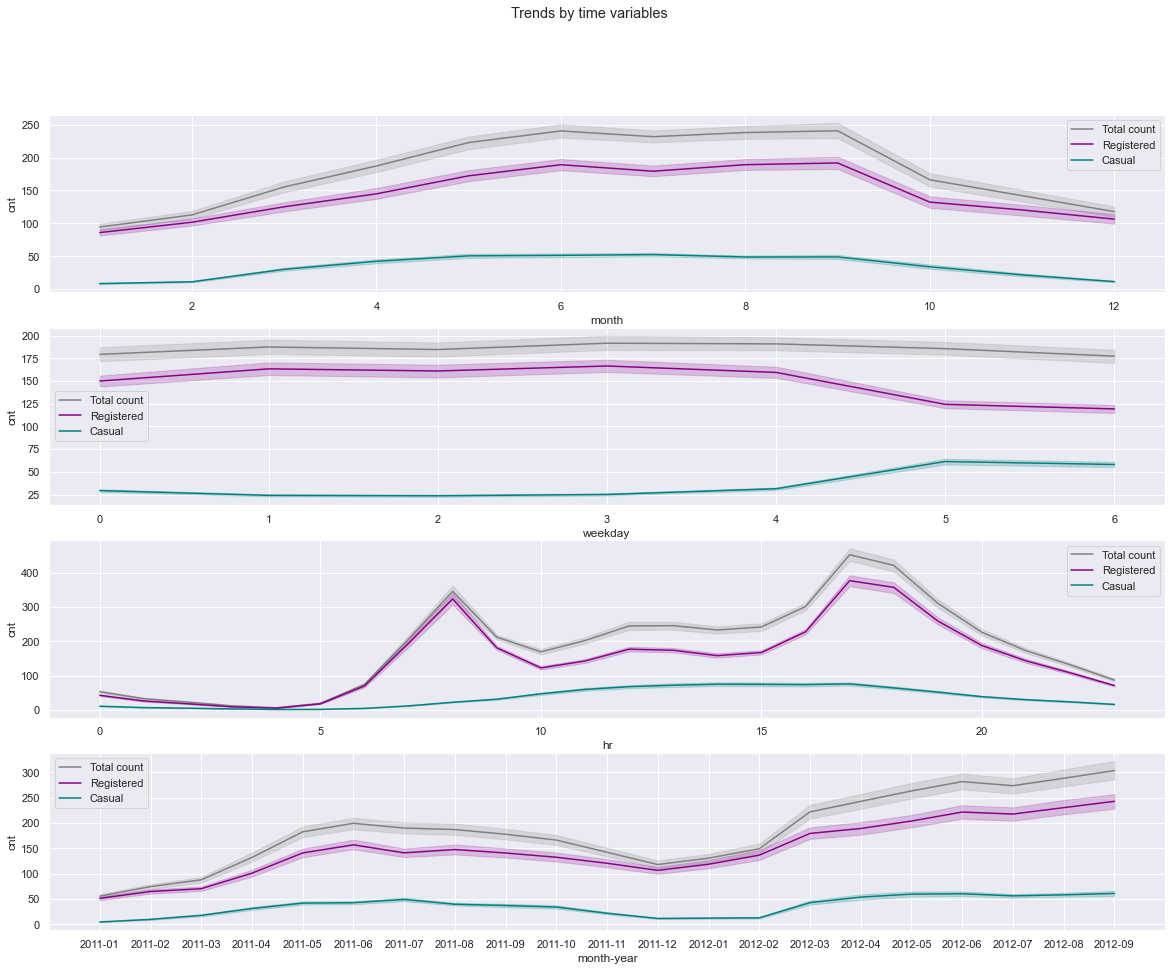

In [42]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 15))

sns.lineplot(x= X_train_copy["month"] , y= y_train ,color="gray", ax=axes[0], label="Total count" )
sns.lineplot(x= X_train_copy["month"] , y= X_train["registered"],color="darkmagenta", ax=axes[0], label="Registered" )
sns.lineplot(x= X_train_copy["month"] , y= X_train["casual"],color="teal", ax=axes[0],  label="Casual" )

sns.lineplot(x= X_train_copy["weekday"] , y= y_train,color="gray", ax=axes[1], label="Total count" )
sns.lineplot(x= X_train_copy["weekday"] , y= X_train["registered"],color="darkmagenta", ax=axes[1], label="Registered" )
sns.lineplot(x= X_train_copy["weekday"] , y= X_train["casual"],color="teal", ax=axes[1],  label="Casual" )

sns.lineplot(x= X_train_copy["hr"] , y= y_train,color="gray", ax=axes[2], label="Total count" )
sns.lineplot(x= X_train_copy["hr"] , y= X_train["registered"],color="darkmagenta", ax=axes[2], label="Registered" )
sns.lineplot(x= X_train_copy["hr"] , y= X_train["casual"],color="teal", ax=axes[2],  label="Casual" )

sns.lineplot(x=X_train_copy["month-year"]  , y= y_train,color="gray", ax=axes[3], label="Total count" )
sns.lineplot(x= X_train_copy["month-year"] , y= X_train["registered"],color="darkmagenta", ax=axes[3], label="Registered" )
sns.lineplot(x= X_train_copy["month-year"] , y= X_train["casual"],color="teal", ax=axes[3],  label="Casual" )

fig.suptitle("Trends by time variables")

We would also analyze patterns within the categorical variables
holiday, weekend

Text(0.5, 0.98, 'Distribution per weekend and holiday. 0= Not weekend/Not holiday, 1= Is weekend/ Is holiday')

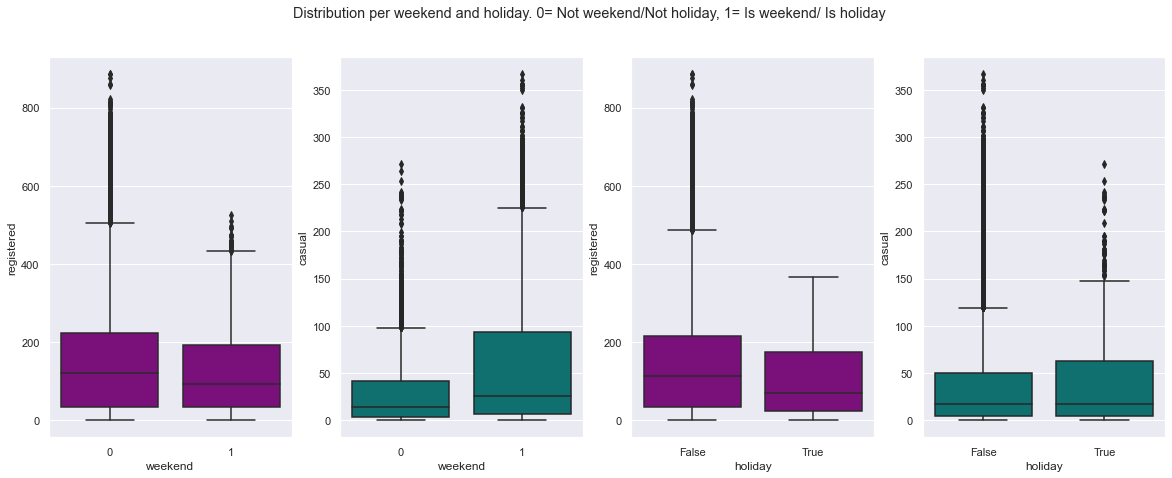

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 7))
sns.boxplot(x= "weekend" , y="registered" , color="darkmagenta",  data= X_train_copy, ax= axes[0])
sns.boxplot(x= "weekend" , y="casual" , color="teal",  data= X_train_copy, ax= axes[1])
sns.boxplot(x= "holiday" , y="registered" , color="darkmagenta",  data= X_train_copy, ax= axes[2])
sns.boxplot(x= "holiday" , y="casual" , color="teal",  data= X_train_copy, ax= axes[3])
fig.suptitle ("Distribution per weekend and holiday. 0= Not weekend/Not holiday, 1= Is weekend/ Is holiday")

After analyzing the previous plots we can have the following conclusions:

-Month: Months around the summer (5,6,7) are the ones with the highest use, while winter months (12, 1, 2) are the ones with the lowest use. Due to this, we would create an additional feature that indicates the corresponding season.

-Weekday/ weekend: Weekends have a lower count of users while weekdays have a higher use (specially Fridays). Weekdays have as well a higher dispersion. This higher dispersion is due to the existing difference within registered and casual users. Which show opposite patterns in weekends. It would be interesting to include both weekday and wekend in the model.

-Holidays: Bikes have a lower use when the day is a holiday and a lower dispersion of the data as well. We would include this categorical variable in the model.

-Hr: There are clear patterns on the hourly data. This is specially evidenced in the registered users. We can tell there are "peak hours" such as 8am, and from 17h to 19h. This would be office hours. Besides, there's another group of hours which are extremely low, which we would call "dead hours" which are probably hours where users are sleeping such as 0h to 5h. The hours that are not within these two groups would be considered as "off peak hours"

In [44]:
def extract_season(series):

    return series.dt.month.map({1: 1,
                       2: 1,
                       3: 1,
                       4: 2,
                       5: 2,
                       6: 2,
                       7: 3,
                       8: 3,
                       9: 3,
                       10: 4,
                       11: 4,
                       12: 4},
                        na_action= "ignore"
                     ).to_frame()

In [45]:
def extract_hrzones(df):
    
    return df.iloc[:,0].map({22:"Dead hours",
                       23: "Dead hours",
                       0: "Dead hours",
                       1: "Dead hours",
                       2: "Dead hours",
                       3: "Dead hours",
                       4: "Dead hours",
                       5: "Dead hours",
                       6: "Dead hours", 
                       7: "Off peak hour",
                       9: "Off peak hour",
                       10: "Off peak hour",
                       11: "Off peak hour",
                       12: "Off peak hour",
                       13: "Off peak hour",
                       14: "Off peak hour",
                       15: "Off peak hour",
                       20: "Off peak hour",
                       21: "Off peak hour", 
                       8:"Peak hours",
                       16:"Peak hours",
                       17:"Peak hours",
                       18:"Peak hours",
                       19:"Peak hours"},
                      na_action= "ignore"
                     ).to_frame()

In [46]:
def extract_daytime(df):
    
    return df.iloc[:,0].map({22:"Night",
                       23: "Night",
                       0: "Night",
                       1: "Night",
                       2: "Night",
                       3: "Night",
                       4: "Night",
                       5: "Night",
                       6: "Day", 
                       7: "Day",
                       9: "Day",
                       10: "Day",
                       11: "Day",
                       12: "Day",
                       13: "Day",
                       14: "Day",
                       15: "Day",
                       20: "Night",
                       21: "Night", 
                       8:"Day",
                       16:"Day",
                       17:"Day",
                       18:"Day",
                       19:"Day"},
                      na_action= "ignore"
                     ).to_frame()

In [47]:
#In order to do the transformations we've evidenced above within a pipeline, we create function transformers for each function
month_extractor = FunctionTransformer(extract_month)
weekday_extractor = FunctionTransformer(extract_weekday)
season_extractor = FunctionTransformer(extract_season)
hrzone_extractor = FunctionTransformer(extract_hrzones)
daytime_extractor = FunctionTransformer(extract_daytime)
weathersit_imputer = FunctionTransformer(impute_last)
holiday_extractor_ni = FunctionTransformer(extract_holiday)
weekend_extractor = FunctionTransformer(extract_weekend)

## 3. Machine Learning (predictive analytics)

### a. Choosing sensible models (linear and non-linear).

We would follow a 2-step forecasting process:

1) Predict the monthly expected users for the period using a time series model.
2) Use this calculated monthly prediction as a feature for a model which calculates the hourly prediction along with the rest of the features.

#### Part 1 of the model. Finding the new additional feature: Monthly prediction:

If we predict hourly data we would have to predict 2168 points. We consider that predicting 3 months instead could be a better approach to be more precise as we would predict aggregated data. 

In [48]:
y_train.set_axis(X_train["dteday"], inplace= True) #Set axis changes the index of the data in a pdseries. We need to change the index as a date to be able to resample the data
y_test.set_axis(X_test["dteday"], inplace= True) #Inplace= True works for rescribing data into y_test
#set axis for series, set index for pdseries. equivalent

Text(0.5, 1.0, 'Users by month')

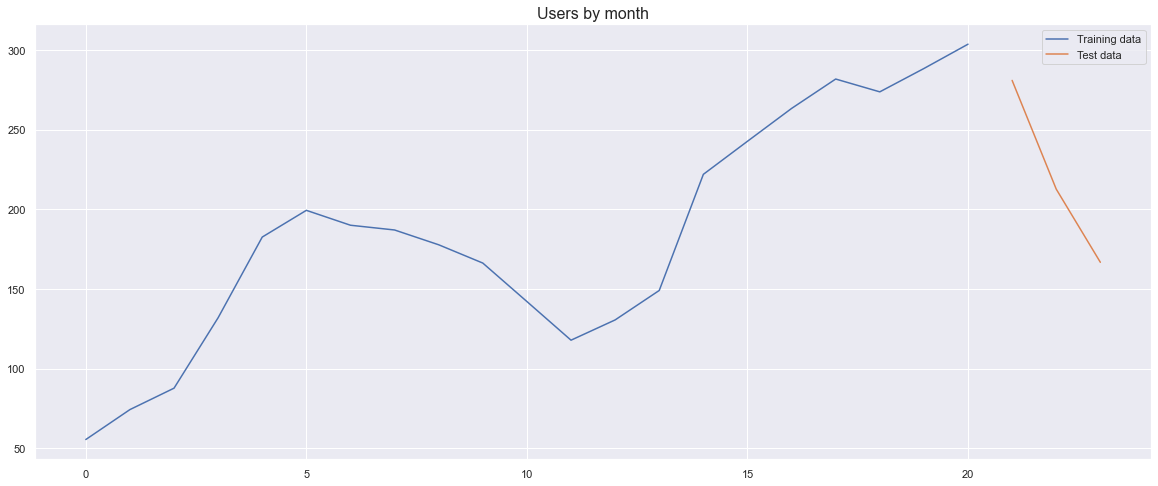

In [49]:
plt.figure (figsize=(20, 8))
y_train_m = y_train.resample('M').mean().reset_index()['cnt'] #We resampled both training and test into monthly data
y_test_m = y_test.resample('M').mean().reset_index()['cnt'].set_axis(range(21,24)) #We are aranging the axis to fit it accordingly to the data
y_train_m.plot(label= "Training data")
y_test_m.plot(label= "Test data")
plt.legend()
plt.title("Users by month", fontsize= 16)

We decided to use a Time Series because we checked the autocorrelation between the months and as we that see the actual's month user count is highly dependant on the previous month's user count. 

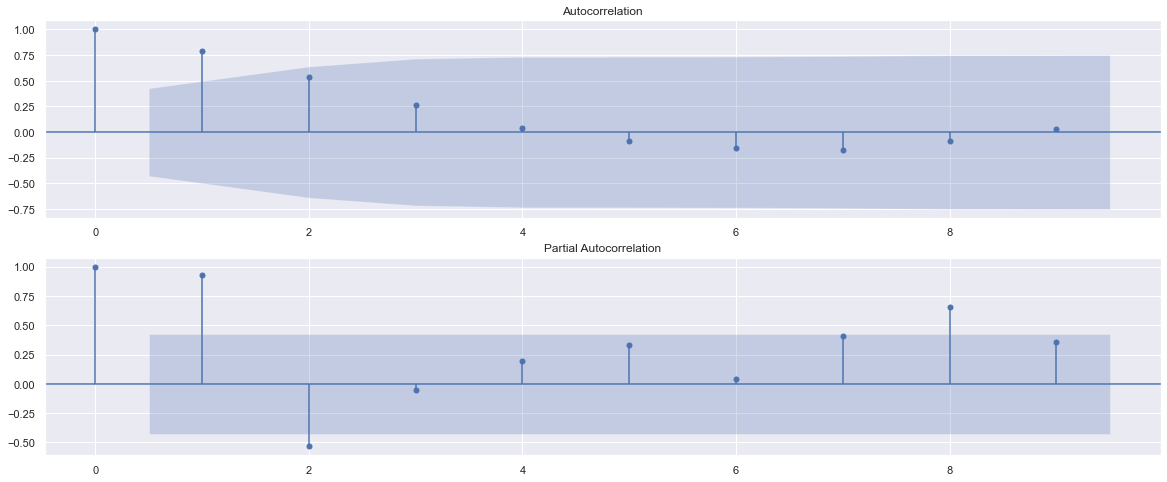

In [50]:
nlags = 9

fig, ax = plt.subplots(2,1, figsize = (20,8))

plot_acf(y_train_m, lags = nlags, ax=ax[0])
plot_pacf(y_train_m, lags = nlags, method="ols", ax=ax[1])
plt.show()

The time series model we chose is a SARIMAX model with parameters (p, d, q)= (0,0,1) and  (P, D, Q)= (1,1,0). We checked it was an appropiate model for the data (significant coefficients, white noise residuals)

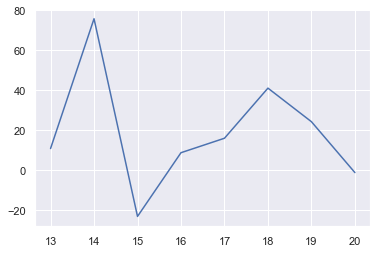

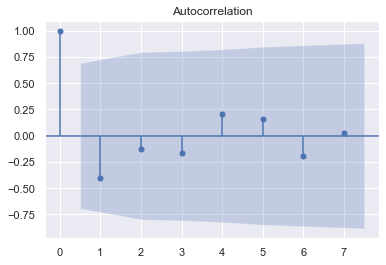

In [51]:
s=12 #We used a seasonality of 12 periods as we are plotting monthly data
fit = SARIMAX(endog = y_train_m, order = (0,0,4), seasonal_order = (1,1,0,s)).fit()
residuos = fit.resid[(s+1):]

plt.plot(residuos)
plt.show()

plot_acf(residuos, lags =7)
plt.show()

Afterwards, we fitted the model and made a monthly prediction (in green)

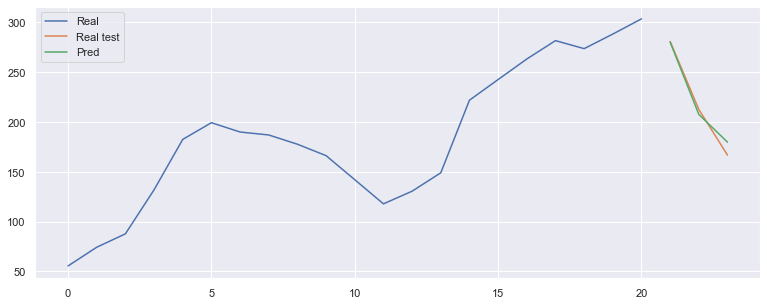

In [52]:
fit_forecast = SARIMAX(endog = y_train_m, order = (0,0,4), seasonal_order = (1,1,0,s)).fit()

y_pred_forecast = fit_forecast.forecast(steps = 3) #Predicting for 3 months


plt.figure(figsize = (13,5))
plt.plot(y_train_m, label = 'Real')
plt.plot(y_test_m, label='Real test')
plt.plot((y_pred_forecast), label = 'Pred')

plt.legend()
plt.show()

The main idea of the two steps model is using the forecasted monthly mean of cnt as an input to predict the cnt per hour. In this sense, we are forecasting based on a previous forecast.

In this order of ideas, we need to train a model that considers the monthly mean of cnt as an input:

- In the following function, we are concatenating the monthly mean of cnt in the train set.

- Afterwards, we are going to concatenate the forecasted monthly mean of cnt in the test set.

In [53]:
def cnt_month(series):
    temp_y = series.to_frame().resample('M').mean().reset_index()
    temp_y['dteday'] = temp_y['dteday'].dt.to_period('M')
    temp_y = temp_y.set_index('dteday')
    temp_x = (X_train.reset_index()['dteday'].dt.to_period('M')).to_frame()
    temp_x = temp_x.set_index('dteday')
    cnt_month = temp_x.join(temp_y, on='dteday', how='left')
    cnt_month = cnt_month.set_index(X_train.index)
    return cnt_month

In [54]:
#Redifining the new X_train and X_test with this new prediction
monthly = cnt_month(y_train)
indexes = y_test.reset_index()['dteday'].dt.to_period('M').to_frame().set_index('dteday')
y_pred_forecast.rename('cnt', inplace=True)
month_test_index = y_test.resample('M').mean().reset_index()['dteday'].dt.to_period('M').to_frame().set_index('dteday').reset_index()['dteday']
y_pred_forecast.set_axis(month_test_index, inplace=True)
prediction_column = indexes.join(y_pred_forecast, on='dteday', how='left').set_axis(X_test.index)
X_train_cnt = pd.concat((X_train, monthly), axis=1)
X_train_cnt = X_train_cnt.reset_index().set_index('instant')
X_test_cnt = pd.concat((X_test, prediction_column), axis=1).reset_index().set_index('instant')

Part 2 of the model: Assembling all features together (including the feature created on previous lines- the monthly predicion)

In [55]:
#Pipelines were created for all of the features which would be transformed in the column transformer
weathersit_enc = make_pipeline(weathersit_imputer, OneHotEncoder(handle_unknown="ignore", sparse=False))
month_enc= make_pipeline(month_extractor, OneHotEncoder(handle_unknown="ignore", sparse= False))
season_enc = make_pipeline(season_extractor, OneHotEncoder(handle_unknown="ignore", sparse=False))
weekday_enc= make_pipeline(weekday_extractor, OneHotEncoder(handle_unknown="ignore", sparse=False))
hrzone_enc= make_pipeline(hrzone_extractor, OneHotEncoder(handle_unknown="ignore", sparse=False))
daytime_enc= make_pipeline(daytime_extractor, OneHotEncoder(handle_unknown="ignore", sparse=False))
holiday_enc= make_pipeline(holiday_extractor_ni, OneHotEncoder(handle_unknown="ignore", sparse=False))
weekend_enc= make_pipeline(weekend_extractor, OneHotEncoder(handle_unknown="ignore", sparse=False))
hr_enc= make_pipeline(OneHotEncoder(handle_unknown="ignore", sparse=False))
knimputer= KNNImputer()

In [56]:
ct = ColumnTransformer([
    ("numerical_encode", knimputer, ["temp", "hum", "windspeed"]),
    ("hr_encode", hr_enc, ["hr"]), 
    ("weathersit_encode", weathersit_enc , "weathersit" ), 
    ("month_encode",month_enc, "dteday"),
    ("season_encode", season_enc, "dteday"),
    ("weekday_encode", weekday_enc, "dteday"),
    ("hrzone_encode", hrzone_enc, ["hr"]),
    ("daytime_encode", daytime_enc, ["hr"]),
    ("holiday_encode", holiday_enc, "dteday"),
    ("weekend_encode", weekend_enc, "dteday"),
    ("pass", "passthrough", ["cnt"]) #Feature created by time series
])
ct

ColumnTransformer(transformers=[('numerical_encode', KNNImputer(),
                                 ['temp', 'hum', 'windspeed']),
                                ('hr_encode',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['hr']),
                                ('weathersit_encode',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function impute_last at 0x7fc4dd423940>)),
                                                 ('onehotencoder',
                                                  OneHot...
                                                  FunctionTransformer(func=<function extract_holiday at 0x7fc4de3715e0>)),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 'dteday'),
                                ('weekend_encode',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function extract_weekend at 0x7fc4de371280>)),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 'dteday'),
                                ('pass', 'passthrough', ['cnt'])])

In [57]:
#Here we can view the new dataframe after transformations
x_transformed= ct.fit_transform(X_test_cnt)
x_transformed= pd.DataFrame(x_transformed)
x_transformed

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.46,0.72,0.1045,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,280.207245
1,0.44,0.77,0.0896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,280.207245
2,0.46,0.72,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,280.207245
3,0.44,0.77,0.0000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,280.207245
4,0.42,0.82,0.1045,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,280.207245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,0.26,0.60,0.1642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,179.737303
2164,0.26,0.60,0.1642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,179.737303
2165,0.26,0.60,0.1642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,179.737303
2166,0.26,0.56,0.1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,179.737303


Defining the five models we would try on out gridsearch

In [58]:
lr= LinearRegression()
rf= RandomForestRegressor()
Lasso = linear_model.Lasso()
Ridge = linear_model.Ridge()
extra = ExtraTreesRegressor()

We tried at some point to do a dimensionality reduction (PCA for numerical variables and K Best for the whole set of variables) however, this worsened the performance of the model when we tried it in the gridsearch. 

In [59]:
pipeline = Pipeline([
    ("preprocessing", ct),
    ('ct_num', ct_numerical),
    #('dim', SelectKBest()),
    ("method", rf),
])
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_encode',
                                                  KNNImputer(),
                                                  ['temp', 'hum', 'windspeed']),
                                                 ('hr_encode',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['hr']),
                                                 ('weathersit_encode',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function impute_last at 0x7fc4dd...
                                                                   FunctionTransformer(func=<function extract_weekend at 0x7fc4de371280>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  'dteday'),
                                                 ('pass', 'passthrough',
                                                  ['cnt'])])),
                ('ct_num',
                 ColumnTransformer(transformers=[('non_encoded',
                                                  FunctionTransformer(func=<function winsor_01 at 0x7fc4dd41c700>),
                                                  slice(0, 3, None)),
                                                 ('encoded', 'passthrough',
                                                  slice(3, 70, None))])),
                ('method', RandomForestRegressor())])

In [60]:
pipeline.fit(X_train_cnt,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_encode',
                                                  KNNImputer(),
                                                  ['temp', 'hum', 'windspeed']),
                                                 ('hr_encode',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['hr']),
                                                 ('weathersit_encode',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function impute_last at 0x7fc4dd...
                                                                   FunctionTransformer(func=<function extract_weekend at 0x7fc4de371280>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  'dteday'),
                                                 ('pass', 'passthrough',
                                                  ['cnt'])])),
                ('ct_num',
                 ColumnTransformer(transformers=[('non_encoded',
                                                  FunctionTransformer(func=<function winsor_01 at 0x7fc4dd41c700>),
                                                  slice(0, 3, None)),
                                                 ('encoded', 'passthrough',
                                                  slice(3, 70, None))])),
                ('method', RandomForestRegressor())])

In [61]:
pipeline.score(X_train_cnt, y_train)

0.9927025737279183

In [62]:
pipeline.score(X_test_cnt, y_test)

0.800256116272037

Here we define the different parameters we would evaluate for the gridsearch.

In [63]:
#n_components = range(1,5)- Dimensionality reduction was not used on the final model
#k = range(44,50)- Dimensionality reduction was not used on the final model
alphas = (10**np.linspace(-1,2,4))
rf_depth = range(5,20) 
imputers= [knimputer, SimpleImputer(strategy='median'), impute_last]
#Alphas and rf parameters were adjusted by taking into account the graph of the result. We did an incremental approach for tuning our grid

In [64]:
param_grid = [
     {'method': [lr],  
               'preprocessing__numerical_encode':imputers}, 
     {'method': [Lasso, Ridge], 
              'method__alpha': alphas, 
              'preprocessing__numerical_encode':imputers},
      {'method': [rf], 
             'method__max_depth': rf_depth, 
              'preprocessing__numerical_encode':imputers
        },
    {'method': [extra], 
             'method__max_depth': rf_depth, 
              'preprocessing__numerical_encode':imputers
        }

]

In [65]:
#Calculation of estimated time to run the grid search
num_par = len(list(ParameterGrid(param_grid)))
et = (num_par / 30)/60
F'Estimated time: {et} hours or {et*60} minutes  or {et*60**2} seconds for Random Forest'

'Estimated time: 0.065 hours or 3.9000000000000004 minutes  or 234.0 seconds for Random Forest'

We can't evaluate the grid search with random splits as we are dealing with time series. For this reason we define a specific time series split.

In [66]:
ts = TimeSeriesSplit(n_splits=5, test_size=2000)

In [67]:
gs = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=ts,
    n_jobs=-1
)
gs.fit(X_train_cnt, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=2000),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical_encode',
                                                                         KNNImputer(),
                                                                         ['temp',
                                                                          'hum',
                                                                          'windspeed']),
                                                                        ('hr_encode',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['hr']),
                                                                        ('weathersit_encode'...
                         {'method': [RandomForestRegressor(max_depth=17)],
                          'method__max_depth': range(5, 20),
                          'preprocessing__numerical_encode': [KNNImputer(),
                                                              SimpleImputer(strategy='median'),
                                                              <function impute_last at 0x7fc4dd423940>]},
                         {'method': [ExtraTreesRegressor()],
                          'method__max_depth': range(5, 20),
                          'preprocessing__numerical_encode': [KNNImputer(),
                                                              SimpleImputer(strategy='median'),
                                                              <function impute_last at 0x7fc4dd423940>]}])

In [68]:
gs_results = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending= False)
gs_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_method,param_preprocessing__numerical_encode,param_method__alpha,param_method__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
63,6.412428,2.307620,0.160405,0.038446,"(DecisionTreeRegressor(max_features='auto', ra...",KNNImputer(),NaN,17,{'method': (DecisionTreeRegressor(max_features...,0.873984,0.698555,0.764359,0.871602,0.900775,0.821855,0.077368,1
54,5.529380,1.909692,0.126244,0.005872,"(DecisionTreeRegressor(max_features='auto', ra...",KNNImputer(),NaN,14,{'method': (DecisionTreeRegressor(max_features...,0.871040,0.706925,0.759135,0.869348,0.893648,0.820019,0.073423,2
60,6.117975,2.272308,0.153832,0.034259,"(DecisionTreeRegressor(max_features='auto', ra...",KNNImputer(),NaN,16,{'method': (DecisionTreeRegressor(max_features...,0.873806,0.694372,0.765296,0.865804,0.900564,0.819968,0.077793,3
66,6.618023,2.460473,0.160465,0.046621,"(DecisionTreeRegressor(max_features='auto', ra...",KNNImputer(),NaN,18,{'method': (DecisionTreeRegressor(max_features...,0.874706,0.691349,0.765077,0.867255,0.900823,0.819842,0.079152,4
69,8.281224,3.122940,0.162000,0.020843,"(DecisionTreeRegressor(max_features='auto', ra...",KNNImputer(),NaN,19,{'method': (DecisionTreeRegressor(max_features...,0.873084,0.684858,0.759352,0.869848,0.898572,0.817143,0.081703,5


In [69]:
best_params = gs.best_params_
best_params

{'method': RandomForestRegressor(max_depth=17),
 'method__max_depth': 17,
 'preprocessing__numerical_encode': KNNImputer()}

In [70]:
gs.best_score_

0.8218551665229457

As we could see, the best results were achieved using random forests. Takin this into account, we plotted the different parameters that were considered for random forests within the tree's depth.

<AxesSubplot:xlabel='param_method__max_depth'>

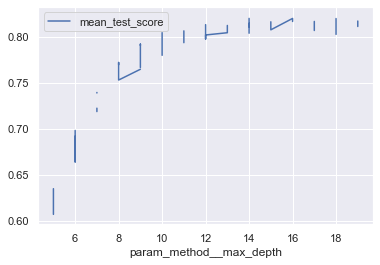

In [71]:
#This part of the code was used for tuning the grid hyperparameters
gs_results.sort_values("param_method__max_depth").plot(
    x="param_method__max_depth", y="mean_test_score"
)

In [72]:
train_size, train_scores, test_scores= learning_curve(pipeline, X_train_cnt, y_train, cv=ts) #we include time series splits as a parameter

In [73]:
train_scores_mean= train_scores.mean(axis=1) #mean across every column- summarizing by row
test_scores_mean= test_scores.mean(axis=1)

In [74]:
train_scores_std= train_scores.std(axis=1) #mean across every column- summarizing by row
test_scores_std= test_scores.std(axis=1)

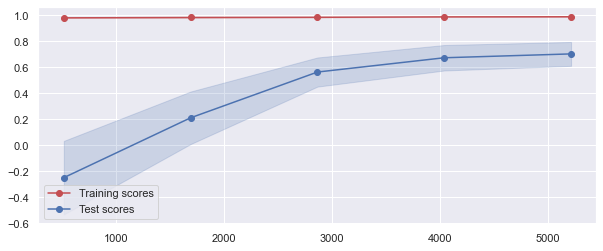

In [75]:
fig, ax= plt.subplots(figsize= (10,4))
ax.plot(train_size, train_scores_mean, 'o-', color= "r", label= "Training scores")
ax.plot(train_size, test_scores_mean, 'o-', color= "b", label= "Test scores")

ax.fill_between(train_size, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color= 'r', alpha= 0.2)
ax.fill_between(train_size, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color= 'b', alpha= 0.2)

ax.legend()

As we can see, the results for the test set and the training set converge after a certain number of iterations

Finally, after having the result we wanted to achieve, we would see the final prediction on the following graph

In [76]:
pipeline.set_params(**best_params)
pipeline.fit(X_train_cnt, y_train)
pipeline.score(X_test_cnt, y_test)

0.8038208239314724

Setting the best params to the pipeline.

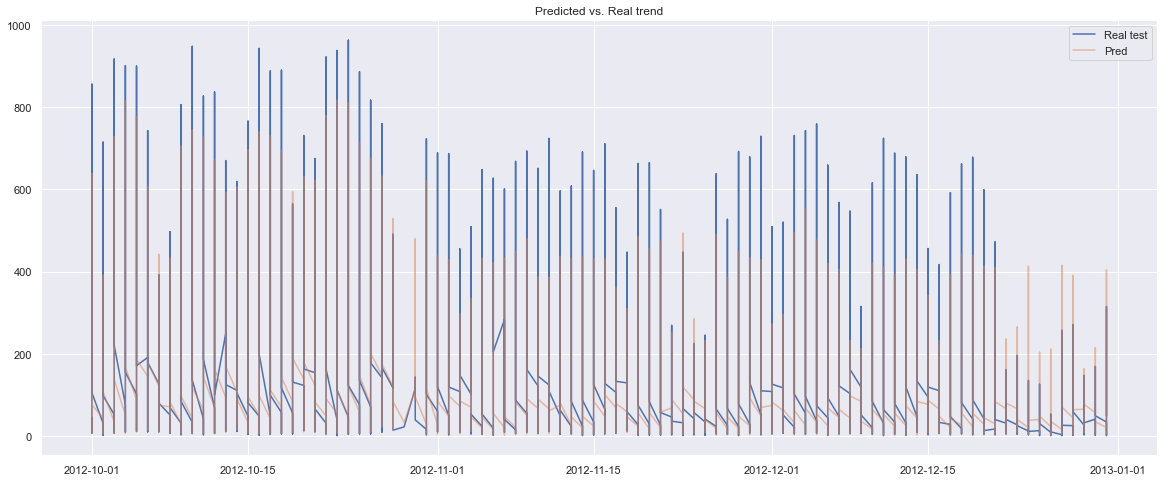

In [77]:
y_predict= pd.Series(pipeline.predict(X_test_cnt)).set_axis(y_test.index) #Axis is set equal to the one of y_test for it to start on the same point

plt.figure(figsize = (20,8))

#plt.plot(y_train, label = 'Real')
plt.plot(y_test, label='Real test')
plt.plot(y_predict, label = 'Pred', alpha=0.5)

plt.legend()
plt.title("Predicted vs. Real trend")
plt.show()